## Business understanding:

- From a report from the CDC motor vehicle safety division, one in five car accidents is caused by a distracted driver. This has just become like drunken driving. Almost 425,000 people injured and 3,000 people killed by distracted driving every year.

- We are aimimg to improve the alarming statistics caused by the distracted driving, by testing whether dashboard cameras can automatically detect drivers engaging in distracted behaviors.
State Farm insurance company has given us a dataset of 2D dashboard camera images, and we need to develop an algorithm to detect and classify driver's behaviour and check if they are driving attentively or not.
We are trying to create machine learning algorithms and deep learning arhitecture to create models and predict and classify them by training them on the given datset.

In [ ]:
# downloading the data from kaggle into colab using curlwget web extension for faster downloads and uploads
# this link is generated everytime we download a dataset, so if needed generate a new link using steps given in read me file
! wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/97.0.4692.71 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/5048/868335/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1642533115&Signature=FwZoqBTWbLi88uTgHixxtlkGZ4Oa7yv0mpJZQB0k0Obwqg8hTVOIY1Toc1%2FuBjQfXRq9yLxox3l0mg3CQZ5lUGnetegvKFfnSiGVrlDKgRBBn%2BFRXtqWJ2aIDU20Qg%2BAd8Qopo7UyVIfLVr2A9n7hLL5sStUeA6gL%2BbJVpPMYEQDTBtrMP1hklx1Fjl4CbKLwiLevBLVI8RN42a1HmXQb2jlDhDZjeF7foysLEGqk6tgO0PzVypQwFWwzghtgWO%2FzaOTxhJygF8gyyHI%2BEBTgWkkWo%2F%2Ftekc5gbaUko3tzwWu9Wo8fV6wXU%2BMZ0kLL3I8yOrfQmVMB984gICV0ct6A%3D%3D&response-content-disposition=attachment%3B+filename%3Dstate-farm-distracted-driver-detection.zip" -c -O 'state-farm-distracted-driver-detection.zip'

In [ ]:
# Unzipping the image files
!unzip state-farm-distracted-driver-detection

In [ ]:
# Importing all the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers
from tensorflow.keras import optimizers
import tensorflow as tf
from keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from sklearn import metrics

## EDA:

In [ ]:
#reading the csv file containing subject Id, class name and image name
df = pd.read_csv("/content/driver_imgs_list.csv")

In [ ]:
# printing the first 5 rows
df.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [ ]:
# appending class name with image name to make it suitable for image data generator
df["img"] = df["classname"] + "/" + df["img"]

In [ ]:
df.head()

,subject,classname,img
0,p002,c0,c0/img_44733.jpg
1,p002,c0,c0/img_72999.jpg
2,p002,c0,c0/img_25094.jpg
3,p002,c0,c0/img_69092.jpg
4,p002,c0,c0/img_92629.jpg


In [ ]:
# count of each subject ID
df["subject"].value_counts()

p021    1237
p022    1233
p024    1226
p026    1196
p016    1078
p066    1034
p049    1011
p051     920
p014     876
p015     875
p035     848
p047     835
p081     823
p012     823
p064     820
p075     814
p061     809
p056     794
p050     790
p052     740
p002     725
p045     724
p039     651
p041     605
p042     591
p072     346
Name: subject, dtype: int64

In [ ]:
# creating a list for the subject IDs that will be our test data
list1 = ["p066","p035","p002","p041" ]

In [ ]:
# creating test dataset
test = df.loc[df["subject"].isin(list1)]

In [ ]:
# creating test dataframe
train = df.loc[~df["subject"].isin(list1)]

In [ ]:
# checking the dimension of test dataset
test.shape

(3212, 3)

In [ ]:
# checking the dimension of train dataset

train.shape

(19212, 3)

In [ ]:
# printing first 5 rows of test dataframe
test.head()

,subject,classname,img
0,p002,c0,c0/img_44733.jpg
1,p002,c0,c0/img_72999.jpg
2,p002,c0,c0/img_25094.jpg
3,p002,c0,c0/img_69092.jpg
4,p002,c0,c0/img_92629.jpg


In [ ]:
# deleting the subject ID column from test data frame 
del test["subject"]

In [ ]:
# deleting the subject ID column from train data frame 
del train["subject"]

In [ ]:
train.head()

,classname,img
725,c0,c0/img_10206.jpg
726,c0,c0/img_27079.jpg
727,c0,c0/img_50749.jpg
728,c0,c0/img_97089.jpg
729,c0,c0/img_37741.jpg


In [ ]:

# Image data generator accepts the original data, randomly transforms it, and returns only the new, transformed data
# rescale = normalizes the pixel value
# validation split = 0.25 , that means 25% of the data is being used for validation
datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.25)

# datagen.flow_from_dataframe = it is a object of image data generator which takes data from a data frame
# directory = it is the path to the directory that contains all the dataset
# x_col = column that contains all the image files
# y_col = column that has the class name (c0,c1, c2.....)
# subset = to specify it as training or validation
# batch size = number of data point in a particular batch
# seed = to generate same random set each time
# class_mode = for training and validation - is categorical- it gives 2D output//for test generator it is set to none so that it returns images
# shuffle = True for train and validation /// for Test generator, shuffle = False, because we need the images in order to predict output and simulatneously match them with their unique IDs
# target size = size of the output image

train_generator=datagen.flow_from_dataframe(
  dataframe=train,
  directory="/content/imgs/train",
  x_col="img",
  y_col="classname",
  subset="training",
  batch_size=32,
  seed=42,
  shuffle=True,
  class_mode="categorical",
  target_size=(256,256)
  )

valid_generator=datagen.flow_from_dataframe(
  dataframe=train,
  directory="/content/imgs/train",
  x_col="img",
  y_col="classname",
  subset="validation",
  batch_size=32,
  seed=42,
  shuffle=True,
  class_mode="categorical",
  target_size=(256,256)
  )

test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
  dataframe=test,
  directory="/content/imgs/train",
  x_col="img",
  y_col=None,
  batch_size=32,
  seed=42,
  shuffle=False, # shuffle = False, because we need the images in order to predict output and simulatneously match them with their unique IDs
  class_mode=None,
  target_size=(256,256)
  )

Found 14409 validated image filenames belonging to 10 classes.
Found 4803 validated image filenames belonging to 10 classes.
Found 3212 validated image filenames.


- Using CNN  Model:

For this project we are using CNN for image classifcation. We are given a dataset of 2D dashboard camera images, so our first choice was CNN as it requires very little pre-processing, meaning that it can read 2D images by applying filters. 

The hidden layers comprise convolutional layers, ReLU activation function, pooling layers, and fully connected layers, all of which play a crucial role. 

Here we have an input layer, an output layer, and hidden layers, all of which help process and classify images. 
Architecture of CNN:
Here we are using sequential model() as it helps to build a model layer by layer.
add() function is used to add layers to our models.
The Conv2D layers are convolution layers. It deals with our input images, which are seen as 2-dimensional matrices.
We use padding = ‘same’ which ensures that the output has the same size as the input.
This layer also has an input shape parameter. This is the shape of each input image, 256,256,3 with the 3 signifying that the images are RGB.

Activation Function adds non-linearity to the network. The activation function used here is ReLu activation function. It is efficient and easy for computation. With ReLu, all the negative values are removed, and the accuracy of the image is increased.
Now we have the pooling layer. It helps in controlling the overfitting of the model. We are using max pooling. It is the process of merging. It helps to extracte the features that are highly important or that are dominant or high lighted in the image. It identifies the largest element, that is, it recognizes the maximum value in each area and thus the image becomes smaller as all the extra information is not considered by the model.

Then we have our drop out layer. It prevents the network from overfitting. 
It deactivates the nodes so that they don't have any effect on the output.
The input to the dense layer should be in 1 dimensional array. So we use the flatten layer to convert the data in to 1 dimensional vector making it suitable for input to the next layer. 

In dense layer each neuron receives input from all the neurons from the preceding layer. This layer can’t have a multidimensional array as an input so flatten layer is used before this layer to get the input in this layer as 1-D array.
This dense layer has softmax activation function. Softmax converts a vector of value to a probability distribution. This function is used for multiclass classification problems. This function here has 10 units (10 neurons). Each of these neurons represent one class as c0, c1, c2 and so on till c9. All these 10 neurons return respective probabilities for the input image. The class which will have the highest probability will be considered as the output for that image.
Then we are configuring the model for training using model.compile(). We are using optimizers to get results faster. We are using RMSprop optimizer ((Root Mean Squared Propagation- it implements RMSprop algorithm). It decreases the number of function evaluations and improves speed and performance for training a specific model.
Here we are considering a learning rate of 0.0001. It helps in configuring our network. When model weights are updated, it helps to control change to the model for the estimated error.
Decay helps to slowly reduce or decay the learning rate so that at the end of the training a local minimum is reached.
We have a loss function = Categorical cross entropy, that is used when we have a multiclass classification problem.
Note: SoftMax activation function is recommended to use, when we are using categorical cross entropy function.




In [ ]:
# model architecture

model = Sequential() # initializing sequential API
model.add(Conv2D(32, (3, 3), padding='same', # Convolutional layer with 32 filters of size 3*3 and padding as same, and input shape as 256*256 wth 3 channels
                 input_shape=(256,256,3)))
model.add(Activation('relu')) # ReLu as activation function
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) # Maxpool of sliding window 2*2
model.add(Dropout(0.25)) # deactivating 25% of the nodes
model.add(Conv2D(64, (3, 3), padding='same')) 
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten()) # flattening(1-D) the output of the previous layer making it suitable for dense layer
model.add(Dense(512)) # fully connected layer with 512 nodes to learn from the features extracted by previous layers
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax')) # output layer with 10 nodes, activation function as softmax becuase its a multi class classification problem

# Using optimizer as RMS prop with learning rate= 0.0001 and decay rate = 1e-6, loss= categorical cross entropy as it is a multi class classification problem,
# and evaluation metrics = accuracy as it is easy to interpret when comparing multiple models.
model.compile(tf.keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6),loss="categorical_crossentropy",metrics=["accuracy"]) 



In [ ]:
# early stopping helps to Stop a training when a monitored metric has stopped improving.
# monitor is the quantity that needs to be monitored to end training. 
# val_loss is for the loss on the validation dataset.
# min_delta is the minimum change in the monitored quantity to be considered as an improvement. Any change less than min_delta, will count as no improvement.
# patience: It specifies number of epochs after which the  training will be stopped if there is no improvement
# model checkpoint - used to save a model at a some interval.
earlystopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=4,
)

modelcheckpoint = tf.keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/distracted_driv_data/model/model.h5",
    monitor="val_loss")
callbacks = [earlystopping, modelcheckpoint]

In [ ]:
#STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
#STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
#STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

# fitting the model using train generator

history = model.fit(train_generator,
                    steps_per_epoch=train_generator.n//train_generator.batch_size,
                    validation_data=valid_generator,
                    validation_steps=valid_generator.n//valid_generator.batch_size,
                    epochs=10, # epochs = training the model 10 times
                    callbacks = callbacks)




Epoch 1/10
450/450 [==============================] - 150s 306ms/step - loss: 0.8122 - accuracy: 0.7344 - val_loss: 5.5131 - val_accuracy: 0.1890
Epoch 2/10
450/450 [==============================] - 136s 302ms/step - loss: 0.1037 - accuracy: 0.9702 - val_loss: 6.0195 - val_accuracy: 0.1619
Epoch 3/10
450/450 [==============================] - 136s 302ms/step - loss: 0.0472 - accuracy: 0.9871 - val_loss: 7.9225 - val_accuracy: 0.1635
Epoch 4/10
450/450 [==============================] - 134s 298ms/step - loss: 0.0310 - accuracy: 0.9907 - val_loss: 9.7968 - val_accuracy: 0.1500
Epoch 5/10
450/450 [==============================] - 134s 297ms/step - loss: 0.0192 - accuracy: 0.9946 - val_loss: 10.6618 - val_accuracy: 0.1615


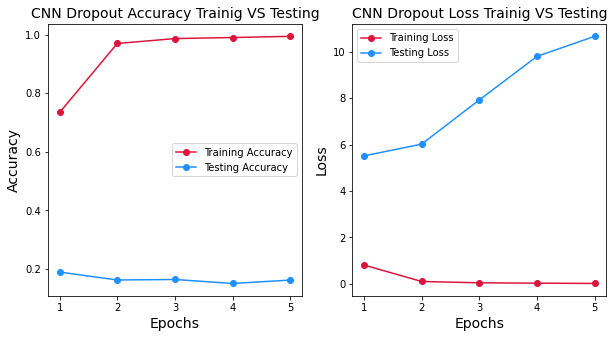

In [ ]:
fig, axes = plt.subplots(1, 2, figsize= (10, 5))
axes[0].plot(range(1, len(history.history['accuracy']) + 1), history.history['accuracy'], linestyle ='solid', marker= 'o', color = 'crimson', label = 'Training Accuracy')
axes[0].plot(range(1, len(history.history['val_accuracy']) + 1), history.history['val_accuracy'], linestyle ='solid', marker= 'o', color = 'dodgerblue', label ='Testing Accuracy')
axes[0].set_xlabel('Epochs', fontsize =14)
axes[0].set_ylabel('Accuracy',fontsize= 14)
axes[0].set_title('CNN Dropout Accuracy Trainig VS Testing', fontsize = 14)
axes[0].legend(loc= 'best')
axes[1].plot(range(1, len(history.history['loss']) + 1), history.history['loss'], linestyle ='solid', marker= 'o', color = 'crimson', label = 'Training Loss')
axes[1].plot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'], linestyle ='solid', marker= 'o', color = 'dodgerblue', label ='Testing Loss')
axes[1].set_xlabel('Epochs', fontsize =14)
axes[1].set_ylabel('Loss',fontsize= 14)
axes[1].set_title('CNN Dropout Loss Trainig VS Testing', fontsize = 14)
axes[1].legend(loc= 'best')
plt.show()

In [ ]:
earlystopping1 = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=4,
)

modelcheckpoint1 = tf.keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/distracted_driv_data/model/model1.h5",
    monitor="val_loss")
callbacks1 = [earlystopping1, modelcheckpoint1]

Here we will be using transfer learning. It is method to take a model that is already trained on a large dataset and then we tranfer its knowledge to a smalller dataset. 
It improves the efficiency when we are training new models.
Here we will be using VGG16 model architecture, this was used for imagenet dataset.

In [ ]:
# Transfer Learning
# Weights = Imagenet ?????????????? what are weights?
# the input layer for this model is is the output of the base model.
# input_shape we are specifying here is (256,256)
# Initializers are used to set the initial random weight for the layers
# we are using he normal initializer
#...........................................................................
# It draws samples from a truncated normal distribution centered on 0 with stddev = sqrt(2 / fan_in) where fan_in is the number of input units in the weight tensor.........
# ........................................................................
# include_to means whether to include the 3 fully-connected layers at the top of the network.
# We have specified input layer as false so we need to specify the input shape. Here we have input shape as (256,256,3) - that is the width , height and 3 input channels.
# Maxpooling is used for feature extraction
# kernel size - specifies the height and the width.
# strides = Specifies the amount by which the filter shifts. 
# we are using adam Adam optimizer(Adaptive Moment Estimation) - it implements the adam algorithm. It is appropriate for non-stationary objects.
# Adam optimizer involves a combination of two gradient descent methodologies: 1) Momentum, 2)Root Mean Square Propagation (RMSP).
# It takes up the positive attribtes from these two methods and builds a more optimized gradient decsent.




tf.keras.backend.clear_session()
base_model = VGG16(weights='imagenet', input_shape = (256, 256, 3), include_top=False)
input_layer = base_model.output

x = Conv2D(filters=32,kernel_size=(3,3),strides=(1,1),padding='valid',activation='relu', 
          kernel_initializer=tf.keras.initializers.he_normal())(input_layer)
x = MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='valid')(x)
x = Flatten()(x)
x = Dense(units=30,activation='relu', kernel_initializer=tf.keras.initializers.he_normal())(x)
x = Dense(units=30,activation='relu', kernel_initializer=tf.keras.initializers.he_normal())(x)
Out = Dense(units=10,activation='softmax', kernel_initializer=tf.keras.initializers.he_normal())(x)
model1 = Model(inputs = base_model.input, outputs = Out)

for layer in base_model.layers:
  layer.trainable = False;
opt = Adam(learning_rate=0.0001)
model1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
#model.summary()


58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
# fitting the model

history1 = model1.fit(train_generator,
                    steps_per_epoch=train_generator.n//train_generator.batch_size,
                    validation_data=valid_generator,
                    validation_steps=valid_generator.n//valid_generator.batch_size,
                    epochs=10,
                    callbacks = callbacks1)

Epoch 1/10
450/450 [==============================] - 141s 296ms/step - loss: 1.2621 - accuracy: 0.6487 - val_loss: 2.1195 - val_accuracy: 0.3306
Epoch 2/10
450/450 [==============================] - 127s 283ms/step - loss: 0.2635 - accuracy: 0.9670 - val_loss: 2.1515 - val_accuracy: 0.3865
Epoch 3/10
450/450 [==============================] - 127s 281ms/step - loss: 0.1004 - accuracy: 0.9881 - val_loss: 2.4180 - val_accuracy: 0.3725
Epoch 4/10
450/450 [==============================] - 121s 269ms/step - loss: 0.0566 - accuracy: 0.9927 - val_loss: 2.4134 - val_accuracy: 0.3952
Epoch 5/10
450/450 [==============================] - 121s 269ms/step - loss: 0.0342 - accuracy: 0.9964 - val_loss: 2.3728 - val_accuracy: 0.3969


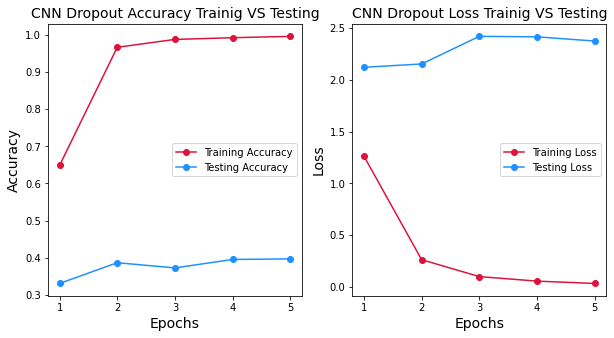

In [ ]:
fig, axes = plt.subplots(1, 2, figsize= (10, 5))
axes[0].plot(range(1, len(history1.history['accuracy']) + 1), history1.history['accuracy'], linestyle ='solid', marker= 'o', color = 'crimson', label = 'Training Accuracy')
axes[0].plot(range(1, len(history1.history['val_accuracy']) + 1), history1.history['val_accuracy'], linestyle ='solid', marker= 'o', color = 'dodgerblue', label ='Testing Accuracy')
axes[0].set_xlabel('Epochs', fontsize =14)
axes[0].set_ylabel('Accuracy',fontsize= 14)
axes[0].set_title('CNN Dropout Accuracy Trainig VS Testing', fontsize = 14)
axes[0].legend(loc= 'best')
axes[1].plot(range(1, len(history1.history['loss']) + 1), history1.history['loss'], linestyle ='solid', marker= 'o', color = 'crimson', label = 'Training Loss')
axes[1].plot(range(1, len(history1.history['val_loss']) + 1), history1.history['val_loss'], linestyle ='solid', marker= 'o', color = 'dodgerblue', label ='Testing Loss')
axes[1].set_xlabel('Epochs', fontsize =14)
axes[1].set_ylabel('Loss',fontsize= 14)
axes[1].set_title('CNN Dropout Loss Trainig VS Testing', fontsize = 14)
axes[1].legend(loc= 'best')
plt.show()

In [ ]:
## Transfer Learning 2

earlystopping2 = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=4,
)

modelcheckpoint2 = tf.keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/distracted_driv_data/model/model2.h5",
    monitor="val_loss")
callbacks2 = [earlystopping2, modelcheckpoint2]

Inception V3  is a well known image recognition model, and it has been used on Imagenet Dataset and has been shown to have achieved greater than 78% accuracy.

In [ ]:
#Here we are using SGD optimizer-  Gradient descent (with momentum) optimizer.


tf.keras.backend.clear_session()
base_model = InceptionV3(weights='imagenet', input_shape = (256, 256, 3), include_top=False)
input_layer = base_model.output

x = Conv2D(filters=32,kernel_size=(3,3),strides=(1,1),padding='valid',activation='relu', 
          kernel_initializer=GlorotNormal())(input_layer)
x = MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='valid')(x)
x = Flatten()(x)
x = Dense(units=30,activation='relu', kernel_initializer=GlorotNormal())(x)
x = Dense(units=30,activation='relu', kernel_initializer=GlorotNormal())(x)
Out = Dense(units=10,activation='softmax', kernel_initializer=GlorotNormal())(x)
model2 = Model(inputs = base_model.input, outputs = Out)

for layer in base_model.layers:
  layer.trainable = False;
opt = SGD(learning_rate=0.0001)
model2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
#model.summary()

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
# fitting the model

history2 = model2.fit(train_generator,
                    steps_per_epoch=train_generator.n//train_generator.batch_size,
                    validation_data=valid_generator,
                    validation_steps=valid_generator.n//valid_generator.batch_size,
                    epochs=10,
                    callbacks = callbacks2)

Epoch 1/10
450/450 [==============================] - 131s 278ms/step - loss: 2.2201 - accuracy: 0.1893 - val_loss: 2.3549 - val_accuracy: 0.1700
Epoch 2/10
450/450 [==============================] - 120s 266ms/step - loss: 1.9020 - accuracy: 0.3347 - val_loss: 2.3926 - val_accuracy: 0.2004
Epoch 3/10
450/450 [==============================] - 118s 261ms/step - loss: 1.6283 - accuracy: 0.4694 - val_loss: 2.4530 - val_accuracy: 0.2138
Epoch 4/10
450/450 [==============================] - 112s 249ms/step - loss: 1.3639 - accuracy: 0.5885 - val_loss: 2.4605 - val_accuracy: 0.2229
Epoch 5/10
450/450 [==============================] - 118s 262ms/step - loss: 1.1286 - accuracy: 0.6937 - val_loss: 2.4790 - val_accuracy: 0.2469


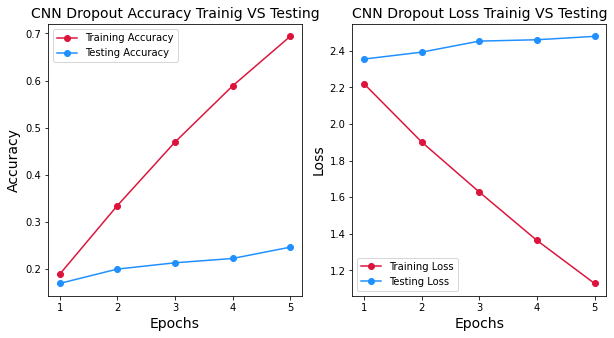

In [ ]:
fig, axes = plt.subplots(1, 2, figsize= (10, 5))
axes[0].plot(range(1, len(history2.history['accuracy']) + 1), history2.history['accuracy'], linestyle ='solid', marker= 'o', color = 'crimson', label = 'Training Accuracy')
axes[0].plot(range(1, len(history2.history['val_accuracy']) + 1), history2.history['val_accuracy'], linestyle ='solid', marker= 'o', color = 'dodgerblue', label ='Testing Accuracy')
axes[0].set_xlabel('Epochs', fontsize =14)
axes[0].set_ylabel('Accuracy',fontsize= 14)
axes[0].set_title('CNN Dropout Accuracy Trainig VS Testing', fontsize = 14)
axes[0].legend(loc= 'best')
axes[1].plot(range(1, len(history2.history['loss']) + 1), history2.history['loss'], linestyle ='solid', marker= 'o', color = 'crimson', label = 'Training Loss')
axes[1].plot(range(1, len(history2.history['val_loss']) + 1), history2.history['val_loss'], linestyle ='solid', marker= 'o', color = 'dodgerblue', label ='Testing Loss')
axes[1].set_xlabel('Epochs', fontsize =14)
axes[1].set_ylabel('Loss',fontsize= 14)
axes[1].set_title('CNN Dropout Loss Trainig VS Testing', fontsize = 14)
axes[1].legend(loc= 'best')
plt.show()

In [ ]:
# Testing

test_model = load_model("/content/drive/MyDrive/distracted_driv_data/model/model.h5")


#img = io.imread()
#img = transform.resize(img, (256, 256, 3))
#img1 = np.expand_dims(img, axis=0)
output = test_model.predict(test_generator)

In [ ]:
#score = model.evaluate(x_test, y_test, verbose=0)
#print('Summary: Loss over the test dataset: %.2f, Accuracy: %.2f' % (score[0], score[1]))

In [ ]:
y_classes = np.array(output.argmax(axis=-1))

In [ ]:
y_classes = y_classes.astype(np.str)

In [ ]:
for i in range (len(y_classes)):
  y_classes[i] = str("c") + y_classes[i]

In [ ]:
y_classes[:50]

array(['c0', 'c0', 'c0', 'c0', 'c0', 'c0', 'c0', 'c0', 'c0', 'c0', 'c0',
       'c0', 'c0', 'c0', 'c0', 'c0', 'c0', 'c0', 'c0', 'c0', 'c6', 'c0',
       'c0', 'c0', 'c0', 'c0', 'c0', 'c0', 'c0', 'c0', 'c0', 'c0', 'c0',
       'c0', 'c0', 'c0', 'c0', 'c0', 'c0', 'c0', 'c0', 'c0', 'c0', 'c0',
       'c0', 'c0', 'c0', 'c0', 'c0', 'c0'], dtype='<U21')

In [ ]:
test["classname"]

0        c0
1        c0
2        c0
3        c0
4        c0
         ..
20436    c9
20437    c9
20438    c9
20439    c9
20440    c9
Name: classname, Length: 3212, dtype: object

In [ ]:
len(y_classes)

3212

In [ ]:

len(test)

3212

In [ ]:
metrics.accuracy_score(test["classname"],y_classes)

0.5084059775840598

In [ ]:
# Model 2 test
test_model1 = load_model("/content/drive/MyDrive/distracted_driv_data/model/model1.h5")

output1 = test_model1.predict(test_generator)


In [ ]:
y_classes1 = np.array(output1.argmax(axis=-1))
y_classes1 = y_classes1.astype(np.str)
for i in range (len(y_classes1)):
  y_classes1[i] = str("c") + y_classes1[i]

y_classes1[:50]

array(['c0', 'c0', 'c5', 'c0', 'c0', 'c0', 'c0', 'c0', 'c0', 'c0', 'c0',
       'c5', 'c5', 'c5', 'c5', 'c5', 'c5', 'c5', 'c5', 'c0', 'c4', 'c5',
       'c5', 'c5', 'c5', 'c5', 'c5', 'c5', 'c5', 'c5', 'c5', 'c5', 'c5',
       'c0', 'c5', 'c5', 'c5', 'c0', 'c0', 'c0', 'c0', 'c0', 'c0', 'c0',
       'c5', 'c5', 'c5', 'c5', 'c5', 'c5'], dtype='<U21')

In [ ]:
metrics.accuracy_score(test["classname"],y_classes1)

0.6413449564134496

In [ ]:
##Testing MOdel 3

test_model2 = load_model("/content/drive/MyDrive/distracted_driv_data/model/model2.h5")

output2 = test_model2.predict(test_generator)


In [ ]:
y_classes2 = np.array(output2.argmax(axis=-1))
y_classes2 = y_classes2.astype(np.str)
for i in range (len(y_classes2)):
  y_classes2[i] = str("c") + y_classes2[i]

y_classes2[:50]

array(['c2', 'c2', 'c2', 'c2', 'c9', 'c9', 'c9', 'c9', 'c9', 'c2', 'c2',
       'c2', 'c2', 'c2', 'c2', 'c2', 'c2', 'c2', 'c2', 'c2', 'c2', 'c2',
       'c2', 'c9', 'c2', 'c2', 'c2', 'c2', 'c2', 'c2', 'c2', 'c2', 'c2',
       'c2', 'c2', 'c2', 'c2', 'c2', 'c2', 'c2', 'c2', 'c2', 'c2', 'c2',
       'c2', 'c2', 'c2', 'c2', 'c2', 'c2'], dtype='<U21')

In [ ]:
metrics.accuracy_score(test["classname"],y_classes2)

0.3894769613947696